# Problema 1 - Word Cloud

## Importar Librerias

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots


import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud
from nltk.util import ngrams
from collections import Counter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-09-29 16:21:33.336798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Carga del Dataset

In [2]:
tweets = pd.read_csv("tw_source.csv", header=None, encoding='latin1',
                     names=['ID', 'Timestamp', 'Fecha', 'Query', 'Usuario', 'Tweet'])
tweets.head()

,ID,Timestamp,Fecha,Query,Usuario,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Análisis del Dataset

### Contabilizar las menciones para determinar los Usuarios mas populares

In [3]:
# Uso de una expresión regular para encontrar menciones
regex_mensiones = tweets['Tweet'].str.findall(r'@(\w+)')

# Crear una lista con todas las menciones 
menciones = [mencion for menciones_tweet in regex_mensiones for mencion in menciones_tweet]

In [4]:
menciones_frecuencia = pd.Series(menciones).value_counts()
menciones_frecuencia = menciones_frecuencia.sort_values(ascending=False)
menciones_frecuencia.head(3)


mileycyrus    4500
tommcfly      3887
ddlovato      3467
Name: count, dtype: int64

In [5]:
# Top ten Usuarios más populares
Top_ten = menciones_frecuencia.head(10)

In [6]:
dataset = Top_ten.reset_index()
dataset.columns = ['Usuario', 'Menciones']

In [7]:
fig = px.bar(dataset, 
             x = 'Usuario', y = 'Menciones',
             text = 'Menciones',
             color_discrete_sequence = px.colors.sequential.gray, 
             title ='Top 10 Usuarios con más menciones',
             template = "simple_white")
fig.update_layout(font = dict(size=17, family = 'Franklin Gothic'))
fig.show()

## Corpus Text

### Creacion del Corpus Text con la información de los usuario más populares. 

In [8]:
# Filtrar los 3 usuarios mas populares 
mas_populares = menciones_frecuencia.head(3)

# Extraer tweets del dataset original
usuarios_mas_populares = mas_populares.index.tolist()
corpus_por_usuario = {}

for usuario in usuarios_mas_populares:
    tweets_usuario = tweets[tweets['Tweet'].str.contains(f'@{usuario}')]
    corpus_por_usuario[usuario] = ' '.join(tweets_usuario['Tweet'])

In [9]:
corpus_mileycyrus = corpus_por_usuario[usuarios_mas_populares[0]]
corpus_tommcfly = corpus_por_usuario[usuarios_mas_populares[1]]
corpus_ddlovato = corpus_por_usuario[usuarios_mas_populares[2]]

## Preprocesamiento de texto

### Eliminar menciones de los usuarios del corpus

In [10]:
def eliminar_menciones(texto):
    # Utilizamos una expresión regular para encontrar y reemplazar las menciones de usuario
    texto_limpio = re.sub(r'@\w+', '', texto)
    return texto_limpio

# Aplicar la función al corpus
corpus_mileycyrus = eliminar_menciones(corpus_mileycyrus)
corpus_tommcfly = eliminar_menciones(corpus_tommcfly)
corpus_ddlovato = eliminar_menciones(corpus_ddlovato)

### Eliminar enlaces a Sitios Web

In [11]:
def eliminar_enlaces(texto):
    # Utilizamos una expresión regular para encontrar y reemplazar los enlaces
    texto_limpio = re.sub(r'http[s]?://\S+', '', texto)
    return texto_limpio

corpus_mileycyrus = eliminar_enlaces(corpus_mileycyrus)
corpus_tommcfly = eliminar_enlaces(corpus_tommcfly)
corpus_ddlovato = eliminar_enlaces(corpus_ddlovato)

### Convertir el texto a minúsculas

In [12]:
corpus_mileycyrus.lower()
corpus_tommcfly.lower()
corpus_ddlovato.lower()

"  ummmmm i cant find it.   do you hate us?? please don't   wish that i could see it..  thats the downside of living in sweden.. good luck anyway   hey demi, wen are you and selena gonna do another video? i miss them   ahhhh i wish i could go to the dallas show...but i wont be near there then   i just saw your tour dates and now i am sad..you come to houston two days before i get home from vacation   sonny with a chance in the uk, only 6 more days. i can't wait, but i'll miss it. i'm at the mcfly concert  hmm .. i'll record it  demii!! how is your stage going to be?? i dont know what kind of seats to look for when i buy them on tuesdayy   hi demi, at which airport in germany were you? if you were in munich i missed you by like a day  if you'd answer that'll be grea  awww. why. omg i really wana c ure new show but it is not out here   hey demi why do you not come to austria???   whyy??!! is not my fault!, my parents are busy for 1th time!  i feel upset... (( (u)  hi,how long are you in 

### Eliminar caracteres especiales y signos de puntuación utilizando expresiones regulares

In [13]:
# Función para limpiar el texto
def limpiar_texto(texto):
    texto_limpio = re.sub(r'[^\w\s]', '', texto)
    return texto_limpio

# Aplicar limpieza de texto a cada corpus
corpus_mileycyrus = limpiar_texto(corpus_mileycyrus)
corpus_tommcfly = limpiar_texto(corpus_tommcfly)
corpus_ddlovato = limpiar_texto(corpus_ddlovato)

### Stemming

In [14]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonmaldosan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonmaldosan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Inicializar el stemmer de Porter
stemmer = PorterStemmer()

# Función para realizar stemming en un texto
def aplicar_stemming(texto):
    # Tokenizar el texto en palabras
    words = word_tokenize(texto)
    
    # Aplicar stemming a cada palabra
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Reconstruir el texto
    stemmed_text = ' '.join(stemmed_words)
    
    return stemmed_text

corpus_mileycyrus = aplicar_stemming(corpus_mileycyrus)
corpus_tommcfly = aplicar_stemming(corpus_tommcfly)
corpus_ddlovato = aplicar_stemming(corpus_ddlovato)

### Lematización

In [16]:
nlp = spacy.load("en_core_web_sm")

# Función para realizar NER y preservar nombres propios en su forma original
def ner_preservar_nombres_propios(corpus):
    # Conversión a minúsculas
    corpus_minusc = corpus.lower()
    
    # Procesar el texto con SpaCy
    doc = nlp(corpus_minusc)
    
    # Normalizar nombres propios
    texto_normalizado = " ".join(token.text if token.ent_type_ == "PERSON" else token.text.lower() for token in doc)
    
    return texto_normalizado

# Aplicar NER a cada corpus
corpus_mileycyrus = ner_preservar_nombres_propios(corpus_mileycyrus)
corpus_tommcfly = ner_preservar_nombres_propios(corpus_tommcfly)
corpus_ddlovato = ner_preservar_nombres_propios(corpus_ddlovato)

### Tokenizacion y eliminacion de stopwords

In [17]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonmaldosan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonmaldosan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
# Definir una lista de stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para tokenizar y eliminar stopwords
def tokenizar_y_eliminar_stopwords(texto):
    # Tokenización
    tokens = word_tokenize(texto, language="english", preserve_line=False)
    
    # Eliminación de stopwords
    tokens_sin_stopwords = [word for word in tokens if word.lower() not in stop_words]
    
    return tokens_sin_stopwords

In [19]:
tokens_mileycyrus = tokenizar_y_eliminar_stopwords(corpus_mileycyrus)
tokens_tommcfly = tokenizar_y_eliminar_stopwords(corpus_tommcfly)
tokens_ddlovato = tokenizar_y_eliminar_stopwords(corpus_ddlovato)

## Resultados

### Contar la frequencia de palabras

In [20]:
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

In [21]:
freq_mileycyrus = Freq_df(tokens_mileycyrus)
freq_tommcfly  = Freq_df(tokens_tommcfly)
freq_ddlovato  = Freq_df(tokens_ddlovato)

In [22]:
fig = px.bar(freq_mileycyrus[:10], 
             x = 'Term', y = 'Frequency',
             text = 'Frequency',
             color_discrete_sequence = px.colors.sequential.gray, 
             title ='Top 10 frequent terms Miley Cyrus', 
             color='Term',template = "simple_white")
fig.update_layout(font = dict(size=17, family = 'Franklin Gothic'))
fig.show()

In [23]:
fig = px.bar(freq_tommcfly[:10], 
             x = 'Term', y = 'Frequency',
             text = 'Frequency',
             color_discrete_sequence = px.colors.sequential.gray, 
             title ='Top 10 frequent terms Tom Mcfly', 
             color='Term',template = "simple_white")
fig.update_layout(font = dict(size=17, family = 'Franklin Gothic'))
fig.show()

In [24]:
fig = px.bar(freq_ddlovato[:10], 
             x = 'Term', y = 'Frequency',
             text = 'Frequency',
             color_discrete_sequence = px.colors.sequential.gray, 
             title ='Top 10 frequent terms Demi Lovato', 
             color='Term',template = "simple_white")
fig.update_layout(font = dict(size=17, family = 'Franklin Gothic'))
fig.show()

## Word Cloud

### Funciones

In [25]:
# Funcion para crear el Word Cloud (20 palabras que mas rodean al usuario)
def Word_Cloud(data, title):
    plt.figure(figsize = (16,10))
    wc = WordCloud(width=700, 
               height=400, 
               max_words=20,
               colormap="twilight",
               background_color="cornsilk").generate_from_frequencies(data)


    plt.imshow(wc, interpolation='bilinear')
    plt.title(title ,fontsize=20)
    plt.axis('off')
    plt.show()

In [26]:
# Convertir la lista de tokens en una cadena de texto
corpus_procesado_mileycyrus = " ".join(tokens_mileycyrus)
corpus_procesado_tommcfly = " ".join(tokens_tommcfly)
corpus_procesado_ddlovato = " ".join(tokens_ddlovato)

In [27]:
# Funcion para extraer  N-gramas
def encontrar_bigramas(corpus):
    # Tokenizar el texto en palabras
    words = nltk.word_tokenize(corpus)
    
    # Generar bi-gramas
    bigrams = list(ngrams(words, 2))
    
    # Contar la frecuencia de los bi-gramas
    bigram_freq = Counter(bigrams)
    
    # Obtener los bi-gramas más frecuentes (puedes ajustar el número)
    top_bigrams = bigram_freq.most_common(10)  # Obtener los 10 bi-gramas más comunes
    
    return top_bigrams

bi_gramas_mileycyrus = encontrar_bigramas(corpus_procesado_mileycyrus)
bi_gramas_tommcfly = encontrar_bigramas(corpus_procesado_tommcfly)
bi_gramas_ddlovato = encontrar_bigramas(corpus_procesado_ddlovato)

### Word Cloud Usuario Miley Cyrus

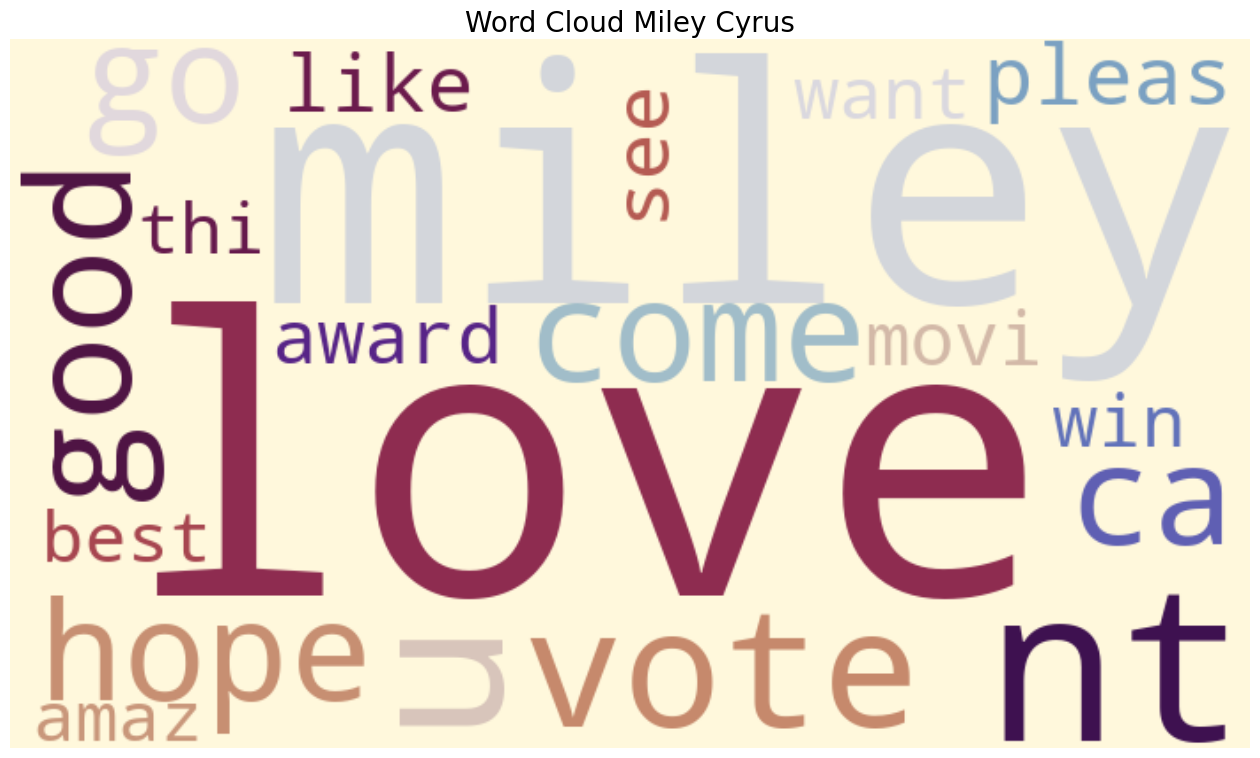

In [28]:
data_mileycyrus = dict(zip(freq_mileycyrus['Term'].tolist(), freq_mileycyrus['Frequency'].tolist()))
data_mileycyrus = freq_mileycyrus.set_index('Term').to_dict()['Frequency']

Word_Cloud(data_mileycyrus, 'Word Cloud Miley Cyrus')

In [29]:
# Bi-grama de las palabras para entender el contexto
bi_gramas_mileycyrus

[(('ca', 'nt'), 303),
 (('good', 'luck'), 137),
 (('love', 'miley'), 96),
 (('hannah', 'montana'), 91),
 (('nt', 'wait'), 88),
 (('gon', 'na'), 87),
 (('hey', 'miley'), 81),
 (('love', 'u'), 69),
 (('movi', 'award'), 69),
 (('mtv', 'movi'), 65)]

### Word cloud Usuario Tom Mcfly

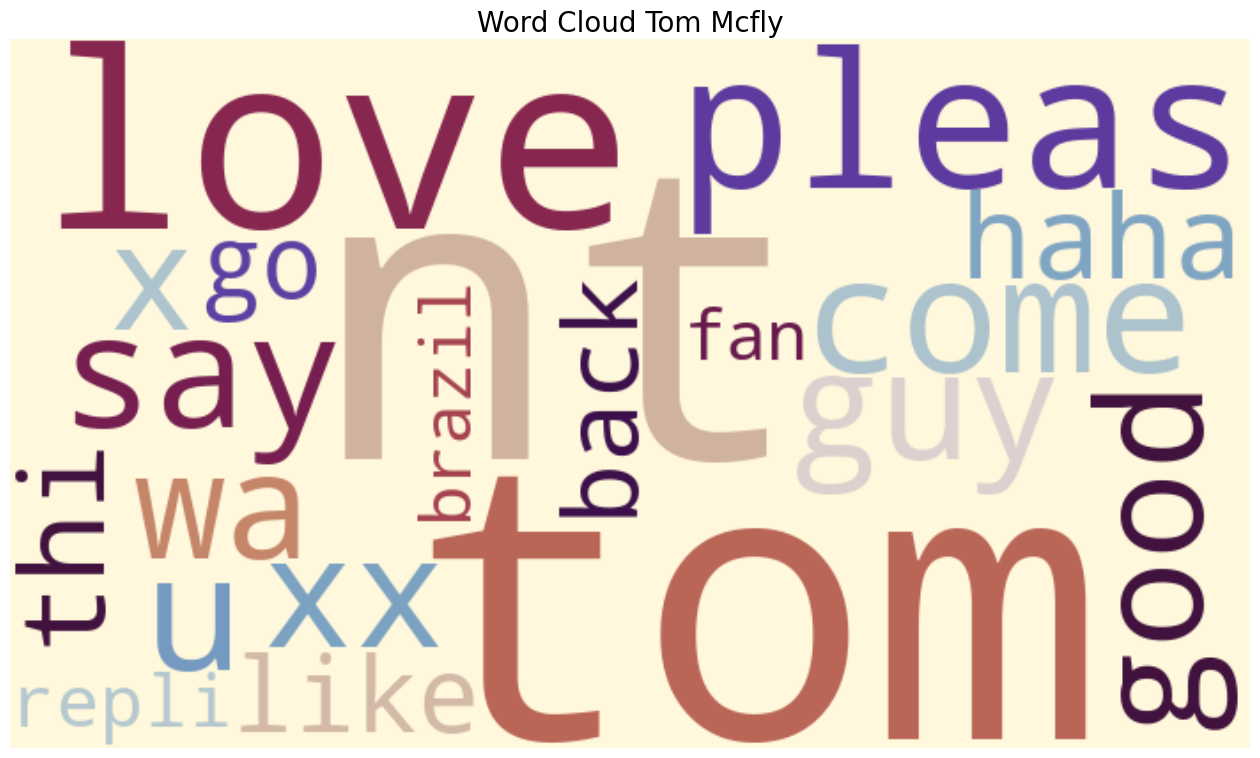

In [30]:
data_tommcfly = dict(zip(freq_tommcfly['Term'].tolist(), freq_tommcfly['Frequency'].tolist()))
data_tommcfly = freq_tommcfly.set_index('Term').to_dict()['Frequency']

Word_Cloud(data_tommcfly, 'Word Cloud Tom Mcfly')

In [31]:
# Bi-grama de las palabras para entender el contexto
bi_gramas_tommcfly

[(('ca', 'nt'), 217),
 (('plz', 'plz'), 124),
 (('come', 'back'), 113),
 (('pleas', 'pleas'), 98),
 (('hey', 'tom'), 91),
 (('say', 'hi'), 87),
 (('nt', 'wait'), 73),
 (('gon', 'na'), 68),
 (('wan', 'na'), 64),
 (('pleas', 'repli'), 52)]

### Word cloud Usuario Demi Lovato

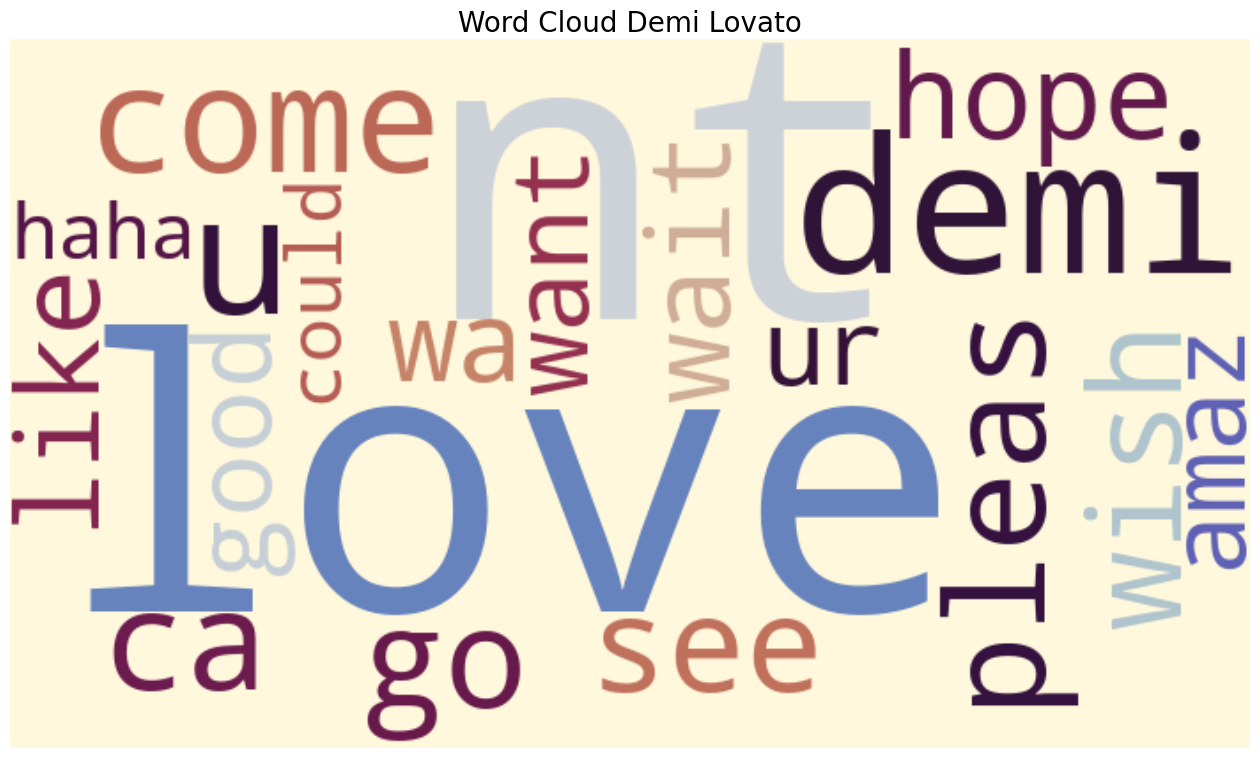

In [32]:
data_ddlovato = dict(zip(freq_ddlovato['Term'].tolist(), freq_ddlovato['Frequency'].tolist()))
data_ddlovato = freq_ddlovato.set_index('Term').to_dict()['Frequency']

Word_Cloud(data_ddlovato, 'Word Cloud Demi Lovato')

In [33]:
# Bi-grama de las palabras para entender el contexto
bi_gramas_ddlovato

[(('ca', 'nt'), 310),
 (('nt', 'wait'), 174),
 (('wish', 'could'), 108),
 (('gon', 'na'), 68),
 (('wan', 'na'), 64),
 (('hey', 'demi'), 59),
 (('pleas', 'repli'), 55),
 (('wo', 'nt'), 54),
 (('new', 'album'), 50),
 (('nt', 'forget'), 47)]

# Problema 2 - Digist Recognizer

## Importar librerias

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.utils import to_categorical

import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization

## Carga del Dataset

In [74]:
mnist = pd.read_csv("train.csv", sep=",")
mnist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dividr el Dataset en conjuntos de Train y Test

In [75]:
df_features = mnist.iloc[:, 1:785]
df_label = mnist.iloc[:, 0]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, 
                                                test_size = 0.2,
                                                random_state = 1212)

Aplicar Reshape al Dataset

In [79]:
print(X_train.shape)
print(X_test.shape)

(33600, 784)
(8400, 784)


In [80]:
X_train = X_train.to_numpy().reshape(33600, 784)
X_test = X_test.to_numpy().reshape(8400, 784)

In [81]:
print((min(X_train[1]), max(X_train[1])))

(0, 255)


In [82]:
# Ajuste para uso en ANN
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)


## Selección del Modelo

In [117]:
# Crear un diccionario para almacenar los resultados de los modelos
resultados = {
    'Modelo': [],
    'Precisión en el conjunto de prueba': []
}

Red Neuronal Artificial (ANN)

In [52]:
# Crear el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # Capa de entrada
    keras.layers.Dense(128, activation='relu'),  # Capa oculta con 128 neuronas y activación ReLU
    keras.layers.Dense(10, activation='softmax') # Capa de salida con 10 neuronas
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20)  

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nPrecisión en el conjunto de prueba:", test_acc)

Epoch 1/20
1050/1050 [==============================] - 2s 2ms/step - loss: 3.9510 - accuracy: 0.8409
Epoch 2/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.5670 - accuracy: 0.8862
Epoch 3/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3692 - accuracy: 0.9142
Epoch 4/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3110 - accuracy: 0.9264
Epoch 5/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.2567 - accuracy: 0.9370
Epoch 6/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.2336 - accuracy: 0.9408
Epoch 7/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.2221 - accuracy: 0.9447
Epoch 8/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.2005 - accuracy: 0.9495
Epoch 9/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.2093 - accuracy: 0.9508
Epoch 10/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.185

In [118]:
# Función para agregar resultados al diccionario
def agregar_resultado(modelo_nombre, precision):
    resultados['Modelo'].append(modelo_nombre)
    resultados['Precisión en el conjunto de prueba'].append(precision)

# Agrega los resultados al diccionario
agregar_resultado('SIMPLE ANN', test_acc)

Red Neuronal Artificial (ANN) + Regularización Dropout

In [54]:
# Crear el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # Capa de entrada
    keras.layers.Dense(128, activation='relu'),  # Capa oculta con 128 neuronas y activación ReLU
    keras.layers.Dropout(0.2),                  # Dropout para regularización y evitar sobreajuste
    keras.layers.Dense(10, activation='softmax') # Capa de salida con 10 neuronas
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20)  

# Evaluar el modelo en el conjunto de prueba
test_loss_1, test_acc_1 = model.evaluate(X_test, y_test)
print("\nPrecisión en el conjunto de prueba:", test_acc_1)

Epoch 1/20
1050/1050 [==============================] - 3s 2ms/step - loss: 3.5709 - accuracy: 0.7337
Epoch 2/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.6904 - accuracy: 0.8235
Epoch 3/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.5419 - accuracy: 0.8571
Epoch 4/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.4717 - accuracy: 0.8724
Epoch 5/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.4242 - accuracy: 0.8865
Epoch 6/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.4009 - accuracy: 0.8913
Epoch 7/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3655 - accuracy: 0.9013
Epoch 8/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3594 - accuracy: 0.9024
Epoch 9/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3435 - accuracy: 0.9113
Epoch 10/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.335

In [119]:
# Agrega los resultados al diccionario
agregar_resultado('ANN + DROPOUT', test_acc_1)


ANN + Cross Validation

In [90]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test) 
y_test = np.array(y_test)

In [91]:
# Crear el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Configurar la validación cruzada (KFold)
num_folds = 5  
kf = KFold(n_splits=num_folds)

# Ciclo de validación cruzada
fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"Entrenando en el pliegue {fold}/{num_folds}")
    
    # Verificar si los pliegues están vacíos
    if len(train_index) == 0 or len(val_index) == 0:
        print(f"Pliegue {fold} está vacío. Continuando con el siguiente pliegue.")
        fold += 1
        continue
    
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Entrenar el modelo en este pliegue
    model.fit(X_fold_train, y_fold_train, epochs=20, verbose=0)  
    
    # Evaluar el modelo en el conjunto de validación de este pliegue
    val_loss, val_acc = model.evaluate(X_fold_val, y_fold_val)
    print(f"Precisión en el conjunto de validación (pliegue {fold}): {val_acc}")
    
    fold += 1

# Evaluar el modelo en el conjunto de prueba
test_loss_2, test_acc_2 = model.evaluate(X_test, y_test)
print("\nPrecisión en el conjunto de prueba:", test_acc_2)

Entrenando en el pliegue 1/5
210/210 [==============================] - 0s 996us/step - loss: 0.4076 - accuracy: 0.9384
Precisión en el conjunto de validación (pliegue 1): 0.9383928775787354
Entrenando en el pliegue 2/5
210/210 [==============================] - 0s 992us/step - loss: 0.2718 - accuracy: 0.9549
Precisión en el conjunto de validación (pliegue 2): 0.9549106955528259
Entrenando en el pliegue 3/5
210/210 [==============================] - 0s 991us/step - loss: 0.2858 - accuracy: 0.9565
Precisión en el conjunto de validación (pliegue 3): 0.9565476179122925
Entrenando en el pliegue 4/5
210/210 [==============================] - 0s 998us/step - loss: 0.2468 - accuracy: 0.9631
Precisión en el conjunto de validación (pliegue 4): 0.9630952477455139
Entrenando en el pliegue 5/5
210/210 [==============================] - 0s 990us/step - loss: 0.1834 - accuracy: 0.9641
Precisión en el conjunto de validación (pliegue 5): 0.9641368985176086
263/263 [==============================] - 0s

In [120]:
# Agrega los resultados al diccionario
agregar_resultado('ANN + CROSS VALIDATION', test_acc_2)

Simple ANN + 4 Hiden layeer

In [93]:
# Reshape de los daatos de Entrenamiento
X_trainn = X_train.reshape(-1, 784)
X_testt = X_test.reshape(-1, 784)

# Convertir las etiquetas a formato "one-hot"
num_digits = 10
y_trainn = to_categorical(y_train, num_digits)
y_testt = to_categorical(y_test, num_digits)

In [94]:
# Definir Hiperparametros
training_epochs = 20
batch_size = 100
n_input = 784 # numero de entradas
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_digits = 10

# Crear el modelo 
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dropout(0.3)(x)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dropout(0.3)(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dropout(0.3)(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

model3 = Model(Inp, output)

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Entrenar el modelo
history = model3.fit(X_trainn, y_trainn,
                    batch_size = batch_size,
                    epochs = training_epochs,
                    validation_data=(X_testt, y_testt))

# Evaluar el modelo en el conjunto de prueba
test_loss_3, test_acc_3 = model3.evaluate(X_testt, y_testt)
print("\nPrecisión en el conjunto de prueba:", test_acc_3)

Epoch 1/20
336/336 [==============================] - 3s 7ms/step - loss: 3.2246 - accuracy: 0.4522 - val_loss: 0.8470 - val_accuracy: 0.7612
Epoch 2/20
336/336 [==============================] - 2s 6ms/step - loss: 1.0443 - accuracy: 0.6872 - val_loss: 0.5976 - val_accuracy: 0.8204
Epoch 3/20
336/336 [==============================] - 2s 6ms/step - loss: 0.7611 - accuracy: 0.7766 - val_loss: 0.4370 - val_accuracy: 0.8858
Epoch 4/20
336/336 [==============================] - 2s 6ms/step - loss: 0.5871 - accuracy: 0.8347 - val_loss: 0.3259 - val_accuracy: 0.9218
Epoch 5/20
336/336 [==============================] - 2s 6ms/step - loss: 0.4776 - accuracy: 0.8684 - val_loss: 0.2689 - val_accuracy: 0.9321
Epoch 6/20
336/336 [==============================] - 2s 6ms/step - loss: 0.4172 - accuracy: 0.8901 - val_loss: 0.2452 - val_accuracy: 0.9407
Epoch 7/20
336/336 [==============================] - 2s 6ms/step - loss: 0.3555 - accuracy: 0.9069 - val_loss: 0.2248 - val_accuracy: 0.9486
Epoch 

In [121]:
# Agrega los resultados al diccionario
agregar_resultado('ANN + 4 Hiden Layer + DROPOUT', test_acc_3)

RED NUERONAL CONVOLUCIONAL (CNN)

In [96]:
# Crear el modelo CNN con Dropout
model_4 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  
    layers.Dense(10, activation='softmax')
])

# Compilar el modelo
model_4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Añadir una dimensión al conjunto de datos para adaptarlo al formato de entrada de la CNN
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Entrenar el modelo
model_4.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
test_loss_4, test_acc_4 = model_4.evaluate(X_test, y_test)
print("\nPrecisión en el conjunto de prueba:", test_acc_4)

Epoch 1/10
1050/1050 [==============================] - 18s 16ms/step - loss: 0.4994 - accuracy: 0.8793 - val_loss: 0.0901 - val_accuracy: 0.9749
Epoch 2/10
1050/1050 [==============================] - 17s 16ms/step - loss: 0.1243 - accuracy: 0.9643 - val_loss: 0.0642 - val_accuracy: 0.9817
Epoch 3/10
1050/1050 [==============================] - 19s 18ms/step - loss: 0.0880 - accuracy: 0.9758 - val_loss: 0.0609 - val_accuracy: 0.9833
Epoch 4/10
1050/1050 [==============================] - 18s 17ms/step - loss: 0.0732 - accuracy: 0.9790 - val_loss: 0.0587 - val_accuracy: 0.9854
Epoch 5/10
1050/1050 [==============================] - 18s 17ms/step - loss: 0.0626 - accuracy: 0.9818 - val_loss: 0.0713 - val_accuracy: 0.9810
Epoch 6/10
1050/1050 [==============================] - 18s 17ms/step - loss: 0.0521 - accuracy: 0.9843 - val_loss: 0.0499 - val_accuracy: 0.9874
Epoch 7/10
1050/1050 [==============================] - 17s 17ms/step - loss: 0.0504 - accuracy: 0.9860 - val_loss: 0.0728 -

In [122]:
# Agrega los resultados al diccionario
agregar_resultado('CNN + DROPOUT', test_acc_4)

Modelo CNN Mejorado

In [98]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)


In [102]:
# Crear el modelo CNN + Batch Normalization
model_5 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])


# Compilar el modelo
model_5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con aumentos de datos
model_5.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
test_loss_5, test_acc_5 = model_5.evaluate(X_test, y_test)
print("\nPrecisión en el conjunto de prueba:", test_acc_5)

Epoch 1/10
336/336 [==============================] - 23s 63ms/step - loss: 0.4981 - accuracy: 0.8508 - val_loss: 0.1341 - val_accuracy: 0.9612
Epoch 2/10
336/336 [==============================] - 21s 63ms/step - loss: 0.1480 - accuracy: 0.9567 - val_loss: 0.0723 - val_accuracy: 0.9770
Epoch 3/10
336/336 [==============================] - 21s 63ms/step - loss: 0.1112 - accuracy: 0.9682 - val_loss: 0.0689 - val_accuracy: 0.9800
Epoch 4/10
336/336 [==============================] - 22s 64ms/step - loss: 0.0886 - accuracy: 0.9731 - val_loss: 0.0438 - val_accuracy: 0.9869
Epoch 5/10
336/336 [==============================] - 21s 64ms/step - loss: 0.0820 - accuracy: 0.9752 - val_loss: 0.0465 - val_accuracy: 0.9861
Epoch 6/10
336/336 [==============================] - 22s 65ms/step - loss: 0.0741 - accuracy: 0.9777 - val_loss: 0.0439 - val_accuracy: 0.9864
Epoch 7/10
336/336 [==============================] - 22s 64ms/step - loss: 0.0642 - accuracy: 0.9794 - val_loss: 0.0450 - val_accuracy:

In [123]:
# Agrega los resultados al diccionario
agregar_resultado('CNN + DROPOUT + BATCH NORM.', test_acc_5)

### RESULTADOS

In [124]:
resultados

{'Modelo': ['SIMPLE ANN',
  'ANN + DROPOUT',
  'ANN + CROSS VALIDATION',
  'ANN + 4 Hiden Layer + DROPOUT',
  'CNN + DROPOUT',
  'CNN + DROPOUT + BATCH NORM.'],
 'Precisión en el conjunto de prueba': [0.9507142901420593,
  0.9452381134033203,
  0.9458333253860474,
  0.9659523963928223,
  0.9873809814453125,
  0.9855952262878418]}

Tabla de Resultados 

In [153]:
tabla_resultados = pd.DataFrame(resultados)
tabla_resultados = tabla_resultados.sort_values(by='Precisión en el conjunto de prueba', ascending=True)
tabla_resultados

,Modelo,Precisión en el conjunto de prueba
1,ANN + DROPOUT,0.945238
2,ANN + CROSS VALIDATION,0.945833
0,SIMPLE ANN,0.950714
3,ANN + 4 Hiden Layer + DROPOUT,0.965952
5,CNN + DROPOUT + BATCH NORM.,0.985595
4,CNN + DROPOUT,0.987381


Grafica de Resultados 

Text(0.5, 0, 'Precisión en el Conjunto de Prueba')

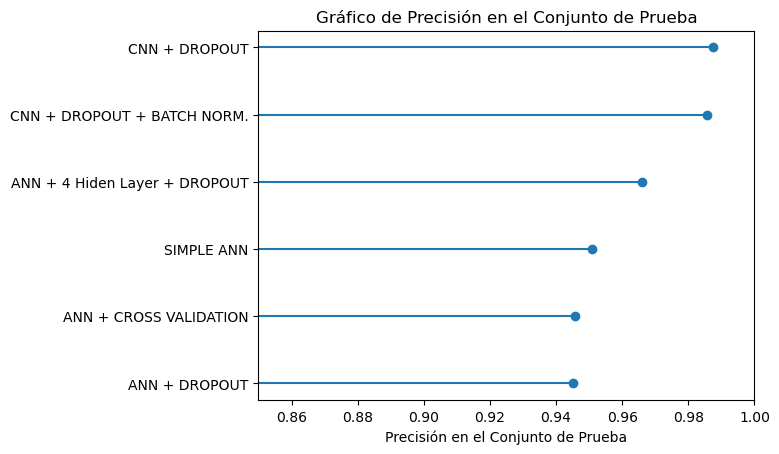

In [160]:
# Datos
x = tabla_resultados['Modelo']
y = tabla_resultados['Precisión en el conjunto de prueba']

# Stem plot
fig, ax = plt.subplots()
ax.stem(x, y, orientation = "horizontal")
ax.set_xlim(0.85, 1)
ax.set_title('Gráfico de Precisión en el Conjunto de Prueba')
ax.set_xlabel('Precisión en el Conjunto de Prueba')
# plt.show()